In [1]:
# Imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge


# Keras for neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Ensure reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# File paths - load Bid and Ask directly
BID_PATH = "USDJPY_1 Min_Bid_2025.06.15_2025.11.10.csv"
ASK_PATH = "USDJPY_1 Min_Ask_2025.06.15_2025.11.10.csv"

In [23]:
print("Bid file path :", BID_PATH)
print("Ask file path :", ASK_PATH)

Bid file path : USDJPY_1 Min_Bid_2025.06.15_2025.11.10.csv
Ask file path : USDJPY_1 Min_Ask_2025.06.15_2025.11.10.csv


In [4]:
# Utility: try to detect timestamp column
def read_csv_with_datetime(path):
    df = pd.read_csv(path)

    # heuristics for datetime column
    datetime_cols = [c for c in df.columns if c.lower() in ('time','date','timestamp','datetime')]

    if not datetime_cols:
        # try to parse any column as datetime
        for c in df.columns:
            try:
                parsed = pd.to_datetime(df[c])
                if parsed.notna().sum() / len(parsed) > 0.5:
                    datetime_cols = [c]
                    break
            except:
                continue

    if not datetime_cols:
        raise ValueError(f"No datetime-like column found in {path}. Columns: {list(df.columns)}")

    dt_col = datetime_cols[0]
    df[dt_col] = pd.to_datetime(df[dt_col])
    df = df.sort_values(dt_col).reset_index(drop=True)
    df = df.set_index(dt_col)

    return df


In [25]:
# Cell 3 – Load data and merge Bid & Ask

print("Loading CSVs...")
if not Path(BID_PATH).exists() or not Path(ASK_PATH).exists():
    raise FileNotFoundError("Bid/Ask CSVs not found in current folder.")

bid = read_csv_with_datetime(BID_PATH)
ask = read_csv_with_datetime(ASK_PATH)

print("Bid shape:", bid.shape)
print("Ask shape:", ask.shape)


def find_price_col(df: pd.DataFrame) -> str:
    """Find a plausible price column."""
    candidates = [
        c for c in df.columns
        if any(k in c.lower() for k in ("price", "bid", "ask", "open", "close"))
    ]
    if candidates:
        return candidates[0]
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric:
        raise ValueError("No numeric columns found as price candidate.")
    return df[numeric].var().idxmax()


bid_price = find_price_col(bid)
ask_price = find_price_col(ask)

bid = bid.rename(columns={bid_price: "Bid"})[["Bid"]]
ask = ask.rename(columns={ask_price: "Ask"})[["Ask"]]

# Merge on datetime index
df = bid.join(ask, how="outer")
df["Bid"] = df["Bid"].ffill().bfill()
df["Ask"] = df["Ask"].ffill().bfill()
df["Mid"] = (df["Bid"] + df["Ask"]) / 2.0

print("Merged df shape:", df.shape)
df.head()


Loading CSVs...
Bid shape: (152640, 5)
Ask shape: (152640, 5)
Merged df shape: (152640, 3)


,Bid,Ask,Mid
Time (EET),,,
2025-06-16 00:00:00,144.038,144.176,144.1070
2025-06-16 00:01:00,144.038,144.176,144.1070
2025-06-16 00:02:00,144.038,144.176,144.1070
2025-06-16 00:03:00,144.038,144.176,144.1070
2025-06-16 00:04:00,143.946,144.101,144.0235



Summary statistics:


,count,mean,std,min,25%,50%,75%,max
Bid,152640.0,148.404306,2.652734,142.707,146.998,147.7330,149.929000,154.4680
Ask,152640.0,148.411433,2.651983,142.713,147.006,147.7410,149.932000,154.4710
Mid,152640.0,148.407869,2.652345,142.710,147.002,147.7375,149.930125,154.4695


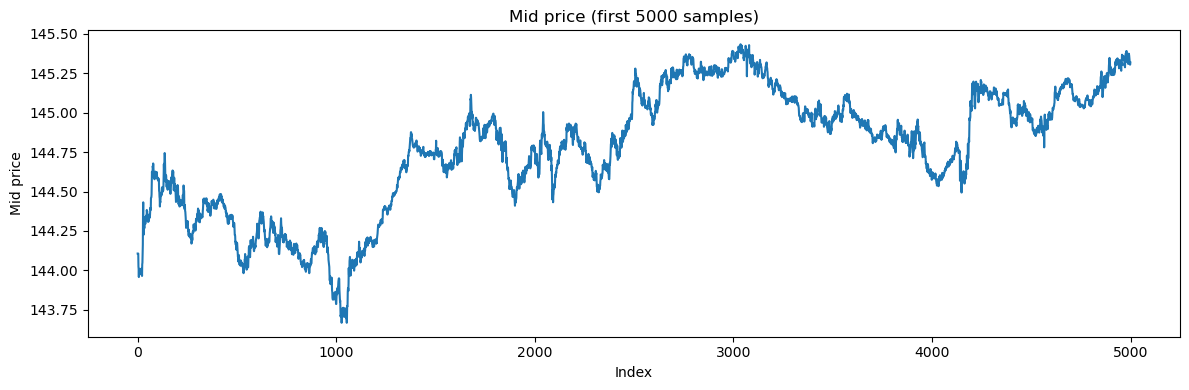

In [26]:
# Cell 4 – Quick EDA

print("\nSummary statistics:")
display(df.describe().T)

plt.figure(figsize=(12, 4))
plt.plot(df["Mid"].iloc[:5000].values)
plt.title("Mid price (first 5000 samples)")
plt.xlabel("Index")
plt.ylabel("Mid price")
plt.tight_layout()
plt.show()


In [27]:
# Merge using outer join on index (datetime). Interpolate any small gaps
df = bid.join(ask, how="outer")

# Forward fill then backward fill missing, just in case
df["Bid"] = df["Bid"].ffill().bfill()
df["Ask"] = df["Ask"].ffill().bfill()

# Create Mid price
df["Mid"] = (df["Bid"] + df["Ask"]) / 2.0
print("Merged dataframe shape:", df.shape)

Merged dataframe shape: (152640, 3)


In [29]:
# Cell 5 – Feature engineering (lightweight to keep model small)

DATA = df.copy()

# Basic returns
DATA["Return"] = DATA["Mid"].pct_change().fillna(0)
DATA["LogRet"] = np.log(DATA["Mid"]).diff().fillna(0)

# Small number of lags
n_lags = 3
for lag in range(1, n_lags + 1):
    DATA[f"ret_lag_{lag}"] = DATA["Return"].shift(lag)
    DATA[f"mid_lag_{lag}"] = DATA["Mid"].shift(lag)

# Few rolling stats
for w in [5, 20]:
    DATA[f"mid_roll_mean_{w}"] = DATA["Mid"].rolling(w).mean()
    DATA[f"mid_roll_std_{w}"] = DATA["Mid"].rolling(w).std()

# Time features
DATA["hour"] = DATA.index.hour
DATA["dayofweek"] = DATA.index.dayofweek

# Targets: next-step mid and return
DATA["target_mid"] = DATA["Mid"].shift(-1)
DATA["target_ret"] = DATA["Return"].shift(-1)

DATA = DATA.dropna().copy()
print("After feature engineering:", DATA.shape)
DATA.head()


After feature engineering: (152620, 19)


,Bid,Ask,Mid,Return,LogRet,ret_lag_1,mid_lag_1,ret_lag_2,mid_lag_2,ret_lag_3,mid_lag_3,mid_roll_mean_5,mid_roll_std_5,mid_roll_mean_20,mid_roll_std_20,hour,dayofweek,target_mid,target_ret
Time (EET),,,,,,,,,,,,,,,,,,,
2025-06-16 00:19:00,143.984,144.035,144.0095,0.000247,0.000247,-0.000042,143.9740,-0.000080,143.9800,-0.000111,143.9915,143.9925,0.015918,144.021575,0.046193,0,0,144.0140,0.000031
2025-06-16 00:20:00,143.985,144.043,144.0140,0.000031,0.000031,0.000247,144.0095,-0.000042,143.9740,-0.000080,143.9800,143.9938,0.017623,144.016925,0.041593,0,0,144.0000,-0.000097
2025-06-16 00:21:00,143.959,144.041,144.0000,-0.000097,-0.000097,0.000031,144.0140,0.000247,144.0095,-0.000042,143.9740,143.9955,0.017755,144.011575,0.035887,0,0,143.9650,-0.000243
2025-06-16 00:22:00,143.888,144.042,143.9650,-0.000243,-0.000243,-0.000097,144.0000,0.000031,144.0140,0.000247,144.0095,143.9925,0.021829,144.004475,0.029492,0,0,144.0385,0.000511
2025-06-16 00:23:00,143.999,144.078,144.0385,0.000511,0.000510,-0.000243,143.9650,-0.000097,144.0000,0.000031,144.0140,144.0054,0.026682,144.001050,0.019108,0,0,144.0490,0.000073


In [30]:
# Cell 6 – Train/test split & scaling (float32 for memory)

feature_cols = [c for c in DATA.columns if c not in ["target_mid", "target_ret"]]
X = DATA[feature_cols]
y_mid = DATA["target_mid"]
y_ret = DATA["target_ret"]

train_size = 0.8
n = len(X)
train_end = int(n * train_size)

X_train, X_test = X.iloc[:train_end], X.iloc[train_end:]
y_mid_train, y_mid_test = y_mid.iloc[:train_end], y_mid.iloc[train_end:]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(
    X_train[numeric_cols].astype("float32")
)
X_test_scaled[numeric_cols] = scaler.transform(
    X_test[numeric_cols].astype("float32")
)

print("Train:", X_train_scaled.shape, "Test:", X_test_scaled.shape)


Train: (122096, 17) Test: (30524, 17)


In [31]:
# Cell 7 – Metrics helper and baseline

def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

# Baseline: persistence (predict last mid_lag_1)
y_pred_baseline = X_test["mid_lag_1"].values
baseline_metrics = evaluate_regression(y_mid_test.values, y_pred_baseline)
print("Baseline persistence metrics:", baseline_metrics)


Baseline persistence metrics: {'mse': 0.000796368292163543, 'rmse': np.float64(0.02821999808936108), 'mae': 0.01875280107456429, 'r2': 0.9994343052100271}


In [33]:
# Cell 8 – Lightweight classical models (RandomForest, GBM, Ridge, SVR-light)

results = {}
models = {}

Xtr = X_train_scaled.astype("float32")
Xte = X_test_scaled.astype("float32")

print("\nTraining classical models...")



Training classical models...


In [34]:
# 1. Light RandomForest with tiny hyperparameter search
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_params = {
    "n_estimators": [40, 80],
    "max_depth": [6, 10],
    "min_samples_split": [2, 5],
}

rs_rf = RandomizedSearchCV(
    rf, rf_params, n_iter=3, cv=3,
    scoring="neg_mean_squared_error",
    random_state=RANDOM_STATE,
)
rs_rf.fit(Xtr, y_mid_train)
models["RandomForest"] = rs_rf.best_estimator_
print("RandomForest best params:", rs_rf.best_params_)

y_pred_rf = models["RandomForest"].predict(Xte)
results["RandomForest"] = evaluate_regression(y_mid_test, y_pred_rf)
print("RandomForest ->", results["RandomForest"])

RandomForest best params: {'n_estimators': 80, 'min_samples_split': 2, 'max_depth': 10}
RandomForest -> {'mse': 0.16687743011039938, 'rmse': np.float64(0.40850634035520106), 'mae': 0.2232677036548148, 'r2': 0.8814597546054227}


In [35]:
# 2. Gradient Boosting (fixed light config)
gb = GradientBoostingRegressor(
    n_estimators=80,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
)
gb.fit(Xtr, y_mid_train)
models["GradientBoosting"] = gb

y_pred_gb = gb.predict(Xte)
results["GradientBoosting"] = evaluate_regression(y_mid_test, y_pred_gb)
print("GradientBoosting ->", results["GradientBoosting"])

GradientBoosting -> {'mse': 0.33931318710203323, 'rmse': np.float64(0.5825059545635849), 'mae': 0.36882592570982226, 'r2': 0.7589711895845848}


In [36]:
# 3. Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(Xtr, y_mid_train)
models["Ridge"] = ridge

y_pred_ridge = ridge.predict(Xte)
results["Ridge"] = evaluate_regression(y_mid_test, y_pred_ridge)
print("Ridge ->", results["Ridge"])

Ridge -> {'mse': 0.0004018877603271544, 'rmse': np.float64(0.020047138457324885), 'mae': 0.013215132441250027, 'r2': 0.9997145217678703}


In [37]:
# 4. SVR on a subsample (fast)
svr_sample = min(8000, len(Xtr))
Xtr_s = Xtr[:svr_sample]
ytr_s = y_mid_train.iloc[:svr_sample]

svr = SVR(C=0.5, epsilon=0.01, kernel="rbf")
svr.fit(Xtr_s, ytr_s)
models["SVR_Light"] = svr

y_pred_svr = svr.predict(Xte)
results["SVR_Light"] = evaluate_regression(y_mid_test, y_pred_svr)
print("SVR_Light ->", results["SVR_Light"])

SVR_Light -> {'mse': 50.58541097564105, 'rmse': np.float64(7.112342158223341), 'mae': 6.944749766325181, 'r2': -34.933002003153184}


Epoch 1/15
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3994.4539 - mae: 45.2633 - val_loss: 1505.7097 - val_mae: 18.4576 - learning_rate: 0.0010
Epoch 2/15
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 640.3465 - mae: 18.5383 - val_loss: 591.8300 - val_mae: 9.0254 - learning_rate: 0.0010
Epoch 3/15
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 485.2615 - mae: 16.7438 - val_loss: 315.9493 - val_mae: 5.9255 - learning_rate: 0.0010
Epoch 4/15
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 424.2792 - mae: 15.9964 - val_loss: 162.2852 - val_mae: 3.5382 - learning_rate: 0.0010
Epoch 5/15
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 391.0074 - mae: 15.4963 - val_loss: 93.9569 - val_mae: 3.3932 - learning_rate: 0.0010
Epoch 6/15
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 363.6944 - mae: 15.0330 - val_loss: 52.2195 - val_mae: 2.3975 - learning_rate: 0.0010
Epoch 7/15
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 350.1322 - mae: 14.7995 - val_loss: 22.5178

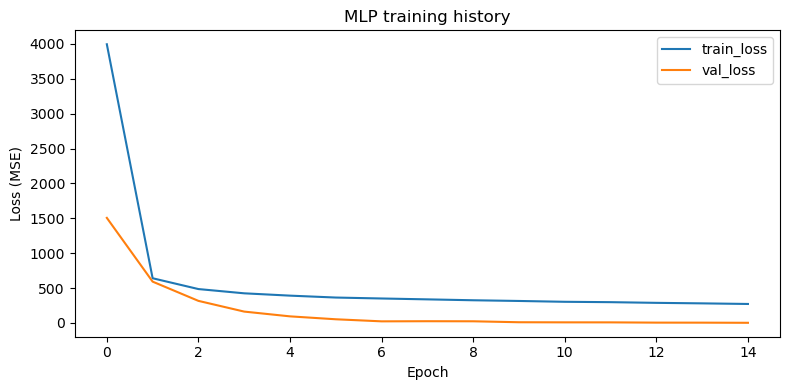

In [38]:
# Cell 9 – Lightweight MLP with early stopping

def build_mlp_light(input_dim, lr=0.001, dropout=0.1):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_dim=input_dim))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1))  # linear output
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

input_dim = Xtr.shape[1]
mlp_light = build_mlp_light(input_dim)

es_mlp = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr_mlp = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

history_mlp = mlp_light.fit(
    Xtr,
    y_mid_train.values,
    validation_split=0.1,
    epochs=15,
    batch_size=64,
    callbacks=[es_mlp, rlr_mlp],
    verbose=1,
)

y_pred_mlp = mlp_light.predict(Xte).flatten()
results["MLP_Light"] = evaluate_regression(y_mid_test, y_pred_mlp)
print("MLP_Light ->", results["MLP_Light"])

plt.figure(figsize=(8, 4))
plt.plot(history_mlp.history["loss"], label="train_loss")
plt.plot(history_mlp.history["val_loss"], label="val_loss")
plt.title("MLP training history")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# Cell 10 – LSTM SequenceGenerator (memory-safe)

class LSTMSequenceGenerator(Sequence):
    def __init__(self, data, target, seq_len, batch_size=32):
        self.data = data
        self.target = target
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.indices = np.arange(seq_len, len(data))

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        Xs = np.zeros(
            (len(batch_idx), self.seq_len, self.data.shape[1]),
            dtype="float32",
        )
        ys = np.zeros(len(batch_idx), dtype="float32")

        for i, t in enumerate(batch_idx):
            Xs[i] = self.data[t - self.seq_len:t]
            ys[i] = self.target[t]

        return Xs, ys


In [40]:
# Cell 11 – Prepare numeric data for LSTM and build generators

seq_length = 20
batch_size = 32

mms = MinMaxScaler()
X_num = X[numeric_cols]
X_num_scaled = mms.fit_transform(X_num).astype("float32")
y_mid_arr = y_mid.reset_index(drop=True).astype("float32").values

train_cut = int(0.8 * len(X_num_scaled))

X_num_train = X_num_scaled[:train_cut]
y_mid_train_arr = y_mid_arr[:train_cut]

X_num_test = X_num_scaled[train_cut:]
y_mid_test_arr = y_mid_arr[train_cut:]

train_gen = LSTMSequenceGenerator(
    X_num_train,
    y_mid_train_arr,
    seq_len=seq_length,
    batch_size=batch_size,
)

test_gen = LSTMSequenceGenerator(
    X_num_test,
    y_mid_test_arr,
    seq_len=seq_length,
    batch_size=batch_size,
)

print("Train sequences per epoch:", len(train_gen), "batches")
print("Test  sequences per epoch:", len(test_gen), "batches")


Train sequences per epoch: 3814 batches
Test  sequences per epoch: 953 batches


Epoch 1/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 1478.7222 - mae: 18.9219 - val_loss: 13.6073 - val_mae: 3.5275
Epoch 2/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 68.9749 - mae: 6.5617 - val_loss: 3.7249 - val_mae: 1.7343
Epoch 3/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 62.4198 - mae: 6.2251 - val_loss: 1.2685 - val_mae: 1.0607
Epoch 4/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 53.4421 - mae: 5.7799 - val_loss: 0.6237 - val_mae: 0.7602
Epoch 5/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 44.2128 - mae: 5.2528 - val_loss: 0.6390 - val_mae: 0.7936
Epoch 6/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 32.0043 - mae: 4.4687 - val_loss: 2.5209 - val_mae: 1.5846
Epoch 7/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 18.1115 - mae: 3.3465 - val_loss: 0.0175 - val_mae: 0.1117
Epoch 8/20
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 6.1127 - mae: 1.9110 - val_loss: 0.0571 - val_mae: 0.2309
Epoch 9/20
3814/3814 

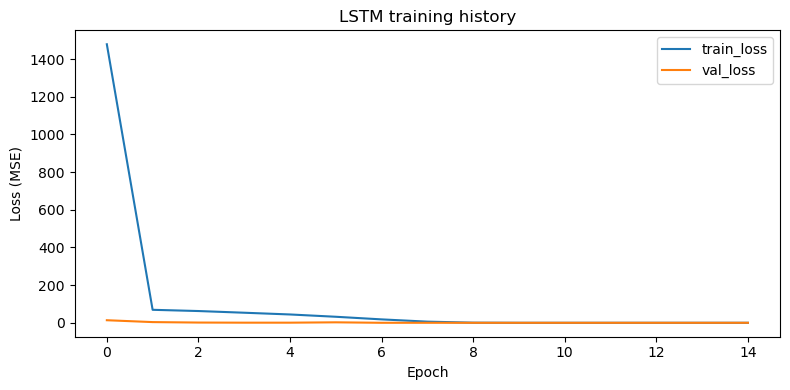

In [41]:
# Cell 12 – Lightweight LSTM model & training

def build_lstm_light(seq_len, n_features):
    model = Sequential()
    model.add(
        LSTM(
            32,
            return_sequences=False,
            input_shape=(seq_len, n_features),
        )
    )
    model.add(Dropout(0.1))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
    return model

lstm_light = build_lstm_light(seq_length, X_num_scaled.shape[1])

es_lstm = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

history_lstm = lstm_light.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    callbacks=[es_lstm],
    verbose=1,
)

# Collect predictions & true values
y_pred_lstm_batches = []
y_true_lstm_batches = []
for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    y_pred_batch = lstm_light.predict(X_batch, verbose=0).flatten()
    y_pred_lstm_batches.append(y_pred_batch)
    y_true_lstm_batches.append(y_batch)

y_pred_lstm = np.concatenate(y_pred_lstm_batches)
y_true_lstm = np.concatenate(y_true_lstm_batches)

results["LSTM_Light"] = evaluate_regression(y_true_lstm, y_pred_lstm)
print("LSTM_Light ->", results["LSTM_Light"])

plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history["loss"], label="train_loss")
plt.plot(history_lstm.history["val_loss"], label="val_loss")
plt.title("LSTM training history")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.show()



Model comparison (lower is better):


,mse,rmse,mae,r2
RandomForest,0.166877,0.408506,0.223268,0.881460
GradientBoosting,0.339313,0.582506,0.368826,0.758971
Ridge,0.000402,0.020047,0.013215,0.999715
SVR_Light,50.585411,7.112342,6.944750,-34.933002
MLP_Light,0.324280,0.569456,0.416784,0.769650
LSTM_Light,0.003120,0.055859,0.041615,0.997784


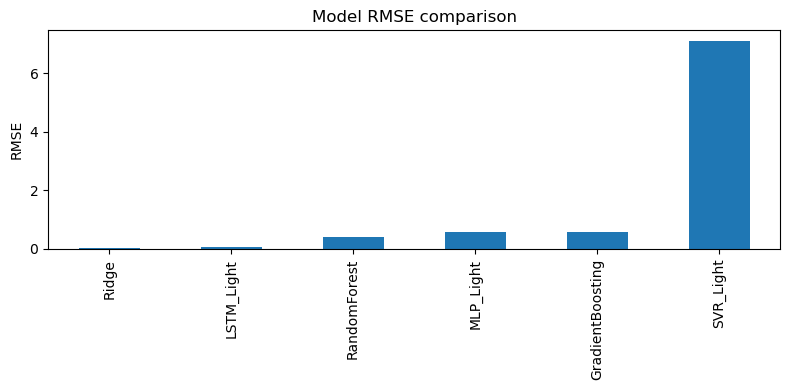

Best model by RMSE: Ridge


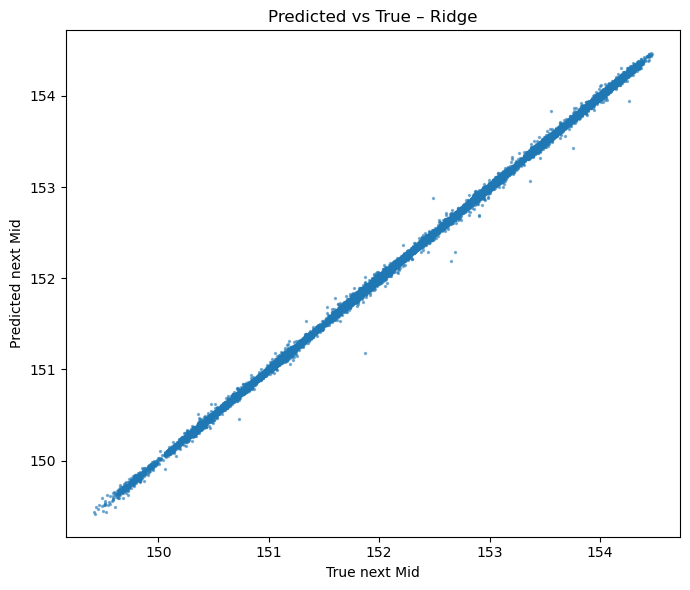

In [42]:
# Cell 13 – Compare model performance & advanced visualisations

metrics_df = pd.DataFrame(results).T
print("\nModel comparison (lower is better):")
display(metrics_df)

plt.figure(figsize=(8, 4))
metrics_df["rmse"].sort_values().plot(kind="bar")
plt.title("Model RMSE comparison")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

best_model_name = metrics_df["rmse"].idxmin()
print("Best model by RMSE:", best_model_name)

# Choose predictions and targets for scatter
if best_model_name == "LSTM_Light":
    y_true_plot = y_true_lstm
    y_pred_plot = y_pred_lstm
elif best_model_name == "MLP_Light":
    y_true_plot = y_mid_test.values
    y_pred_plot = y_pred_mlp
else:
    y_true_plot = y_mid_test.values
    if best_model_name == "RandomForest":
        y_pred_plot = y_pred_rf
    elif best_model_name == "GradientBoosting":
        y_pred_plot = y_pred_gb
    elif best_model_name == "Ridge":
        y_pred_plot = y_pred_ridge
    elif best_model_name == "SVR_Light":
        y_pred_plot = y_pred_svr
    else:
        y_pred_plot = y_pred_baseline  # fallback

plt.figure(figsize=(7, 6))
plt.scatter(y_true_plot, y_pred_plot, s=2, alpha=0.5)
plt.xlabel("True next Mid")
plt.ylabel("Predicted next Mid")
plt.title(f"Predicted vs True – {best_model_name}")
plt.tight_layout()
plt.show()
